In [ ]:
!pip install numpy --trusted-host pypi.org --trusted-host files.pythonhosted.org
!pip install pillow --trusted-host pypi.org --trusted-host files.pythonhosted.org
!pip install scikit-learn --trusted-host pypi.org --trusted-host files.pythonhosted.org
!pip install tensorflow --trusted-host pypi.org --trusted-host files.pythonhosted.org
!pip install matplotlib --trusted-host pypi.org --trusted-host files.pythonhosted.org


In [ ]:
#ck basic model

Label distribution:
happy: 207 images
contempt: 54 images
fear: 75 images
surprise: 249 images
sadness: 84 images
anger: 135 images
disgust: 177 images


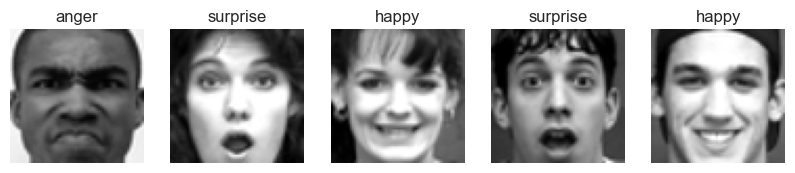

Running configuration: No Data Augmentation
Test Accuracy: 91.37%
Precision: 1.00
Recall: 0.95
F1 Score: 0.98

Summary of Results:
Configuration 1: No Data Augmentation
Test Accuracy: 91.37%
Precision: 1.00
Recall: 0.95
F1 Score: 0.98


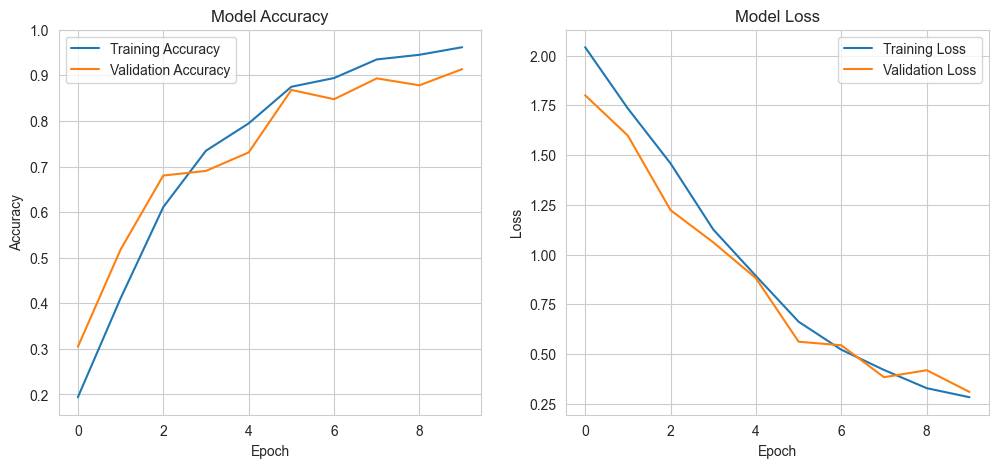

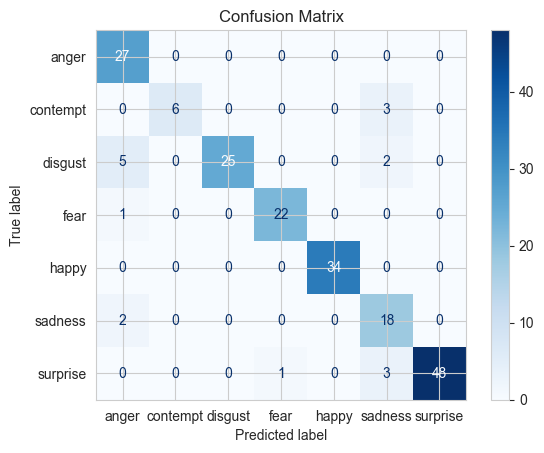

In [2]:
import os
import random
import numpy as np
from collections import Counter
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, InputLayer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
tf.get_logger().setLevel('ERROR')

# Set seeds for reproducibility
def set_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.keras.utils.set_random_seed(seed)
    tf.config.experimental.enable_op_determinism()

set_seeds(42)

# Define the path to the dataset folder
dataset_folder = r'C:/Users/user/Downloads/Thesis/linda_trials/CK+ Dataset'

# Function to load images and extract labels
def load_images_and_labels(base_folder):
    images = []
    labels = []
    for label_folder in os.listdir(base_folder):
        label_path = os.path.join(base_folder, label_folder)
        if os.path.isdir(label_path):
            for filename in os.listdir(label_path):
                if filename.endswith('.png'):
                    image_file = os.path.join(label_path, filename)
                    img = Image.open(image_file).convert('L')  # Convert to grayscale
                    img = img.resize((64, 64))  # Resize to 64x64 for consistency
                    img_array = np.array(img) / 255.0  # Normalize pixel values to [0, 1]
                    images.append(img_array)
                    labels.append(label_folder)  # The folder name is the label
    return np.array(images), np.array(labels)

# Load images and labels
images, labels = load_images_and_labels(dataset_folder)
images = images.reshape(-1, 64, 64, 1)  # Reshape for CNN input

# Display a few sample images with labels
def display_sample_images(images, labels, label_encoder, num_samples=5):
    plt.figure(figsize=(10, 5))
    indices = np.random.choice(len(images), num_samples, replace=False)
    for i, index in enumerate(indices):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[index].reshape(64, 64), cmap='gray')
        plt.title(label_encoder.inverse_transform([labels[index]])[0])
        plt.axis('off')
    plt.show()

# Check for class imbalance
label_counts = Counter(labels)
print("Label distribution:")
for label, count in label_counts.items():
    print(f"{label}: {count} images")

# Convert labels to one-hot encoding
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_categorical = to_categorical(labels_encoded)

# Display sample images before proceeding
display_sample_images(images, labels_encoded, label_encoder, num_samples=5)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels_categorical, test_size=0.2, random_state=42)

# Calculate class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels_encoded),
    y=labels_encoded
)
class_weights_dict = dict(enumerate(class_weights))

# Define the CNN architecture function
def create_model():
    model = Sequential([
        InputLayer(input_shape=(64, 64, 1)),  # Input layer for 64x64 grayscale images
        Conv2D(32, kernel_size=(3, 3), activation='relu'),  # First convolution layer
        MaxPooling2D(pool_size=(2, 2)),  # First pooling layer
        Flatten(),  # Flatten the output for the dense layer
        Dense(100, activation='relu'),  # Fully connected layer
        Dense(len(np.unique(labels_encoded)), activation='softmax')  # Output layer with one neuron per class
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Initialize list to store results
results = []

# No data augmentation configuration
config = {
    "shear_range": 0.0,
    "zoom_range": 0.0,
    "rotation_range": 0,
    "width_shift_range": 0.0,
    "height_shift_range": 0.0,
    "horizontal_flip": False
}

print(f"Running configuration: No Data Augmentation")

# Create the model
model = create_model()

# Define data augmentation configuration (with no augmentation)
datagen = ImageDataGenerator(
    shear_range=config["shear_range"],
    zoom_range=config["zoom_range"],
    rotation_range=config["rotation_range"],
    width_shift_range=config["width_shift_range"],
    height_shift_range=config["height_shift_range"],
    horizontal_flip=config["horizontal_flip"]
)

# Fit the data generator to the training data
datagen.fit(X_train)

# Train the model using class weights and the data generator
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32, seed=42),
    validation_data=(X_test, y_test),
    epochs=10,
    class_weight=class_weights_dict,
    verbose=0  # Suppress epoch prints
)

# Evaluate the model and store the results
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
predictions = model.predict(X_test, verbose=0)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Calculate precision, recall, and F1 score
precision = tf.keras.metrics.Precision()
precision.update_state(true_classes, predicted_classes)
recall = tf.keras.metrics.Recall()
recall.update_state(true_classes, predicted_classes)
f1_score = 2 * (precision.result().numpy() * recall.result().numpy()) / (precision.result().numpy() + recall.result().numpy())

# Store the configuration and results
config_results = {
    'config': 'No Data Augmentation',
    'test_accuracy': test_acc,
    'precision': precision.result().numpy(),
    'recall': recall.result().numpy(),
    'f1_score': f1_score
}

# Print the results for this configuration
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Precision: {precision.result().numpy():.2f}")
print(f"Recall: {recall.result().numpy():.2f}")
print(f"F1 Score: {f1_score:.2f}")
print("="*50)

results.append(config_results)

print("\nSummary of Results:")
for idx, result in enumerate(results):
    print(f"Configuration {idx+1}: {result['config']}")
    print(f"Test Accuracy: {result['test_accuracy']*100:.2f}%")
    print(f"Precision: {result['precision']:.2f}")
    print(f"Recall: {result['recall']:.2f}")
    print(f"F1 Score: {result['f1_score']:.2f}")
    print("="*50)

# Plot accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


### **Dataset Preprocessing:**
- **Images**: Grayscale, resized to 64x64 pixels.
- **Normalization**: Pixel values normalized to [0, 1].
- **Reshaping**: Images reshaped to `(64, 64, 1)`.

### **Label Processing:**
- **Label Encoding**: Labels encoded using `LabelEncoder` and converted to one-hot encoding.

### **Data Splitting:**
- **Train/Test Split**: 80% training and 20% testing split.

### **Class Weights:**
- **Handling Imbalance**: Class weights computed to balance the training process.

### **CNN Architecture:**
1. **Input Layer**: `(64, 64, 1)` shape for grayscale images.
2. **Conv2D Layer**: 32 filters, `(3x3)` kernel, ReLU activation.
3. **MaxPooling2D**: `(2x2)` pool size to reduce dimensions.
4. **Flatten Layer**: Converts 2D feature maps to 1D vector.
5. **Dense Layer**: 100 neurons, ReLU activation.
6. **Output Layer**: Softmax activation with neurons equal to the number of classes.

### **Model Compilation:**
- **Optimizer**: Adam.
- **Loss Function**: Categorical cross-entropy.
- **Metrics**: Accuracy.

### **Data Augmentation:**
- **Configuration**: No data augmentation applied.

### **Model Training:**
- **Epochs**: 10.
- **Batch Size**: 32.
- **Class Weights**: Applied during training.

### **Evaluation Metrics:**
- **Metrics Calculated**: Test accuracy, precision, recall, F1 score.
- **Confusion Matrix**: Used to visualize classification performance.

### **Visualization:**
- **Plots**: Accuracy and loss over epochs, and confusion matrix.

In [ ]:
# model with data aug

Label distribution:
anger: 135 images
contempt: 54 images
disgust: 177 images
fear: 75 images
happy: 207 images
sadness: 84 images
surprise: 249 images
Running configuration: Data Augmentation- horizontal_flip: True
Test Accuracy: 89.85%
Precision: 1.00
Recall: 0.95
F1 Score: 0.98

Summary of Results:
Configuration 1: Data Augmentation
Test Accuracy: 89.85%
Precision: 1.00
Recall: 0.95
F1 Score: 0.98


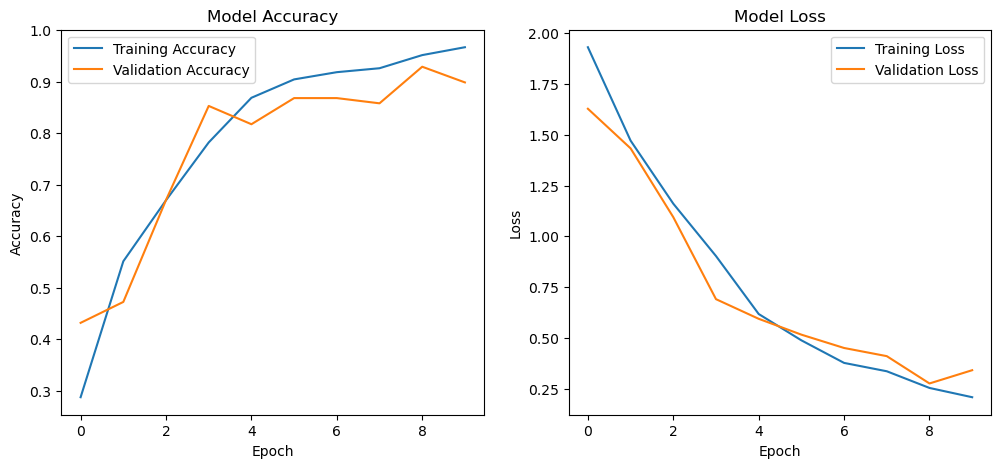

In [1]:
import os
import random
import numpy as np
from collections import Counter
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, InputLayer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
tf.get_logger().setLevel('ERROR')

# Set seeds for reproducibility
def set_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.keras.utils.set_random_seed(seed)
    tf.config.experimental.enable_op_determinism()

set_seeds(42)

# Define the path to the dataset folder
dataset_folder = r"C:\Users\user\Downloads\Thesis\coding\datasets\CK+"

# Function to load images and extract labels
def load_images_and_labels(base_folder):
    images = []
    labels = []
    for label_folder in os.listdir(base_folder):
        label_path = os.path.join(base_folder, label_folder)
        if os.path.isdir(label_path):
            for filename in os.listdir(label_path):
                if filename.endswith('.png'):
                    image_file = os.path.join(label_path, filename)
                    img = Image.open(image_file).convert('L')  # Convert to grayscale
                    img = img.resize((64, 64))  # Resize to 64x64 for consistency
                    img_array = np.array(img) / 255.0  # Normalize pixel values to [0, 1]
                    images.append(img_array)
                    labels.append(label_folder)  # The folder name is the label
    return np.array(images), np.array(labels)

# Load images and labels
images, labels = load_images_and_labels(dataset_folder)
images = images.reshape(-1, 64, 64, 1)  # Reshape for CNN input

# Check for class imbalance
label_counts = Counter(labels)
print("Label distribution:")
for label, count in label_counts.items():
    print(f"{label}: {count} images")

# Convert labels to one-hot encoding
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_categorical = to_categorical(labels_encoded)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels_categorical, test_size=0.2, random_state=42)

# Calculate class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels_encoded),
    y=labels_encoded
)
class_weights_dict = dict(enumerate(class_weights))

# Define the CNN architecture function
def create_model():
    model = Sequential([
        InputLayer(input_shape=(64, 64, 1)),  # Input layer for 64x64 grayscale images
        Conv2D(32, kernel_size=(3, 3), activation='relu'),  # First convolution layer
        MaxPooling2D(pool_size=(2, 2)),  # First pooling layer
        # Conv2D(64, kernel_size=(3, 3), activation='relu'),  # Second convolution layer
        # MaxPooling2D(pool_size=(2, 2)),  # Second pooling layer
        Flatten(),  # Flatten the output for the dense layer
        Dense(100, activation='relu'),  # Fully connected layer
        Dense(len(np.unique(labels_encoded)), activation='softmax')  # Output layer with one neuron per class
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Initialize list to store results
results = []

# data augmentation configuration
config = {
    "shear_range": 0.0,
    "zoom_range": 0.0,
    "rotation_range": 0,
    "width_shift_range": 0.0,
    "height_shift_range": 0.0,
    "horizontal_flip": True
}

print(r"Running configuration: Data Augmentation- horizontal_flip: True")

# Create the model
model = create_model()

# Define data augmentation configuration (with no augmentation)
datagen = ImageDataGenerator(
    shear_range=config["shear_range"],
    zoom_range=config["zoom_range"],
    rotation_range=config["rotation_range"],
    width_shift_range=config["width_shift_range"],
    height_shift_range=config["height_shift_range"],
    horizontal_flip=config["horizontal_flip"]
)

# Fit the data generator to the training data
datagen.fit(X_train)

# Train the model using class weights and the data generator
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32, seed=42),
    validation_data=(X_test, y_test),
    epochs=10,
    class_weight=class_weights_dict,
    verbose=0  # Suppress epoch prints
)

# Evaluate the model and store the results
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
predictions = model.predict(X_test, verbose=0)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

precision = tf.keras.metrics.Precision()
precision.update_state(true_classes, predicted_classes)
recall = tf.keras.metrics.Recall()
recall.update_state(true_classes, predicted_classes)
f1_score = 2 * (precision.result().numpy() * recall.result().numpy()) / (precision.result().numpy() + recall.result().numpy())

# Store the configuration and results
config_results = {
    'config': 'Data Augmentation',
    'test_accuracy': test_acc,
    'precision': precision.result().numpy(),
    'recall': recall.result().numpy(),
    'f1_score': f1_score
}

# Print the results for this configuration
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Precision: {precision.result().numpy():.2f}")
print(f"Recall: {recall.result().numpy():.2f}")
print(f"F1 Score: {f1_score:.2f}")
print("="*50)

results.append(config_results)

print("\nSummary of Results:")
for idx, result in enumerate(results):
    print(f"Configuration {idx+1}: {result['config']}")
    print(f"Test Accuracy: {result['test_accuracy']*100:.2f}%")
    print(f"Precision: {result['precision']:.2f}")
    print(f"Recall: {result['recall']:.2f}")
    print(f"F1 Score: {result['f1_score']:.2f}")
    print("="*50)

# Plot accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


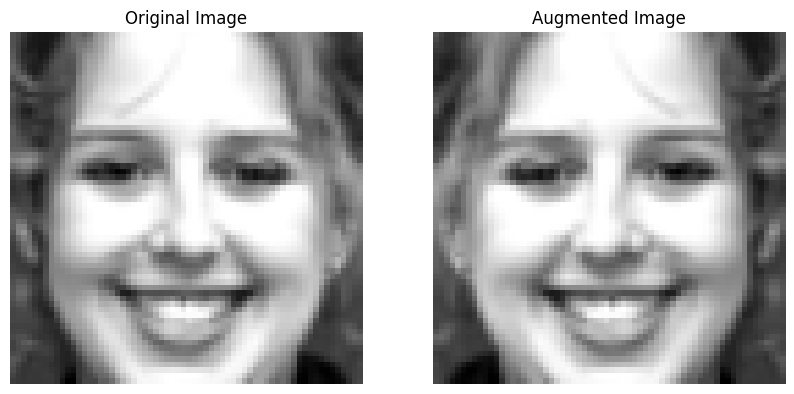

In [2]:
# Select a random image from the training set
index = random.randint(0, len(X_train) - 1)
original_image = X_train[index]

# Create a batch with the selected image to apply augmentation
image_batch = np.expand_dims(original_image, axis=0)

# Generate an augmented image using the data generator
augmented_image = datagen.flow(image_batch, batch_size=1, seed=42).next()[0]

# Plot the original and augmented image side by side
plt.figure(figsize=(10, 5))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(original_image.squeeze(), cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Augmented Image
plt.subplot(1, 2, 2)
plt.imshow(augmented_image.squeeze(), cmap='gray')
plt.title('Augmented Image')
plt.axis('off')

plt.show()


<Figure size 1000x800 with 0 Axes>

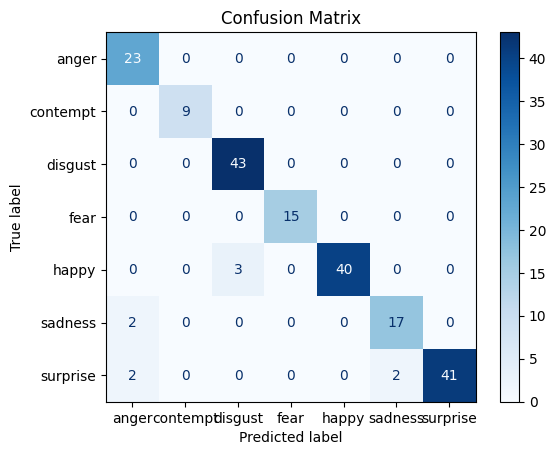

In [3]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Display the confusion matrix using sklearn's ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_encoder.classes_)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()


You're correct; the horizontal flip is indeed configured in this model. Here's the updated summary with the inclusion of the horizontal flip detail:

### **Dataset Preprocessing:**
- **Images**: Grayscale, resized to 64x64 pixels.
- **Normalization**: Pixel values normalized to [0, 1].
- **Reshaping**: Images reshaped to `(64, 64, 1)`.

### **Label Processing:**
- **Label Encoding**: Labels encoded using `LabelEncoder` and converted to one-hot encoding.

### **Data Splitting:**
- **Train/Test Split**: 80% training and 20% testing split.

### **Class Weights:**
- **Handling Imbalance**: Class weights computed to balance the training process.

### **CNN Architecture:**
1. **Input Layer**: `(64, 64, 1)` shape for grayscale images.
    2. **Conv2D Layer**: 32 filters, `(3x3)` kernel, ReLU activation.
3. **MaxPooling2D**: `(2x2)` pool size to reduce dimensions.
4. **Flatten Layer**: Converts 2D feature maps to 1D vector.
5. **Dense Layer**: 100 neurons, ReLU activation.
6. **Output Layer**: Softmax activation with neurons equal to the number of classes.

### **Model Compilation:**
- **Optimizer**: Adam.
- **Loss Function**: Categorical cross-entropy.
- **Metrics**: Accuracy.

### **Data Augmentation:**
- **Configuration**: Horizontal flipping enabled (`horizontal_flip=True`). No other augmentation applied.

### **Model Training:**
- **Epochs**: 10.
- **Batch Size**: 32.
- **Class Weights**: Applied during training.

### **Evaluation Metrics:**
- **Metrics Calculated**: Test accuracy, precision, recall, F1 score.

### **Visualization:**
- **Plots**: Accuracy and loss over epochs.

In [ ]:
#ck cnn optimization

Training Configuration 1: {'conv_layers': 1, 'filters': 64, 'dense_layers': 1, 'dense_units': 64, 'dropout': 0.2, 'epochs': 50, 'batch_size': 32, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'}


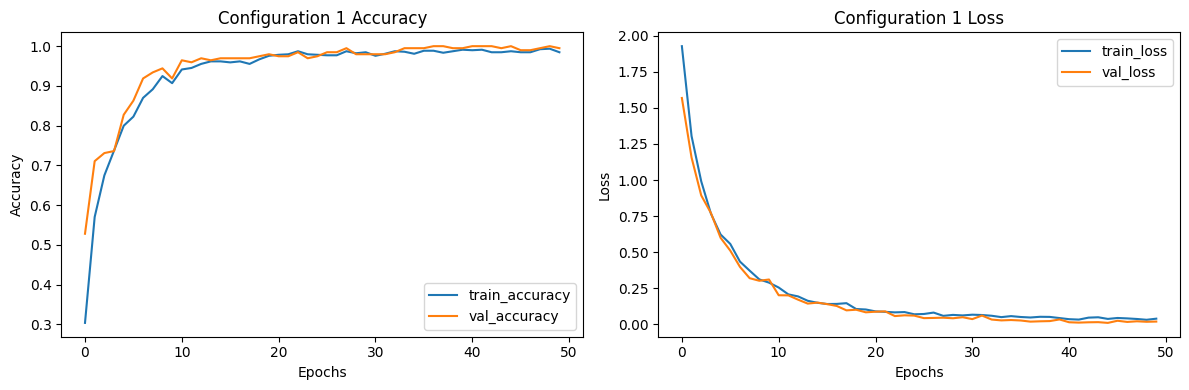

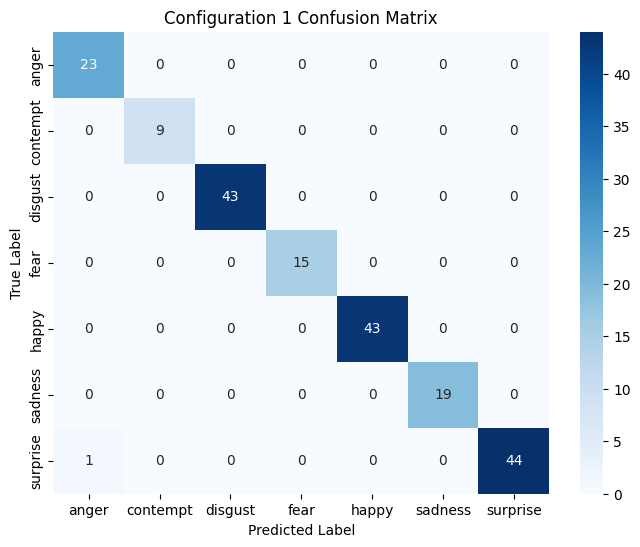

Test Accuracy: 0.9949, Precision: 0.9951, Recall: 0.9949, F1 Score: 0.9949
Test Loss: 0.0190
Training Configuration 2: {'conv_layers': 2, 'filters': 32, 'dense_layers': 1, 'dense_units': 64, 'dropout': 0.2, 'epochs': 30, 'batch_size': 32, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'}


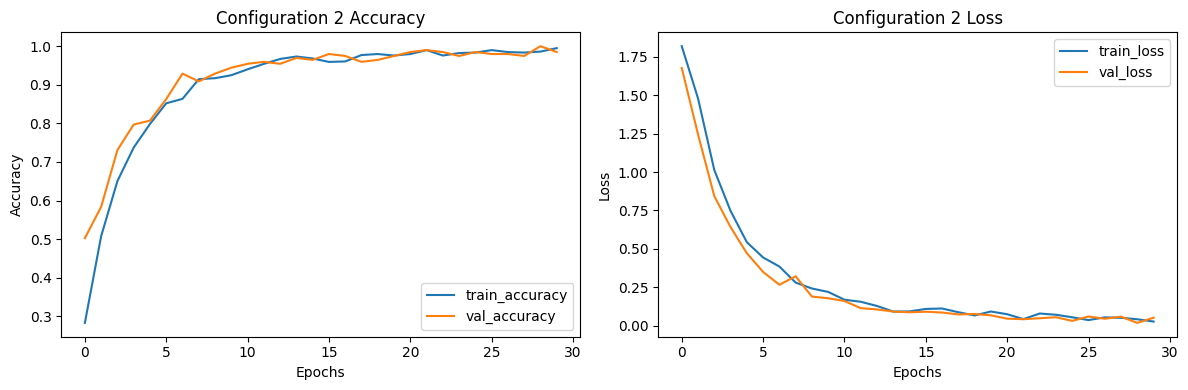

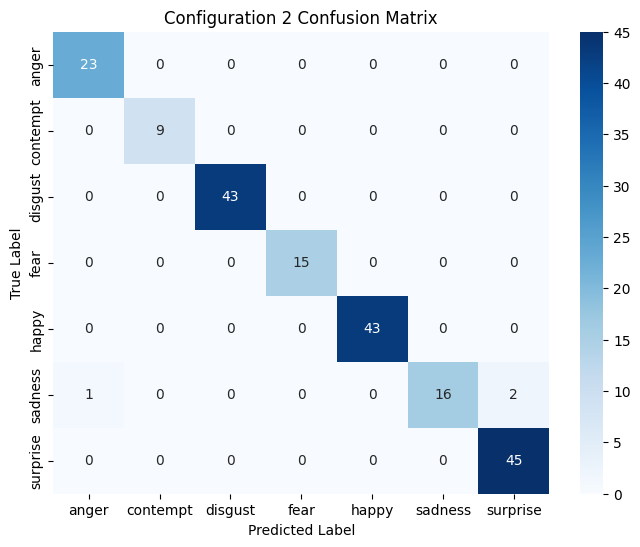

Test Accuracy: 0.9848, Precision: 0.9854, Recall: 0.9848, F1 Score: 0.9843
Test Loss: 0.0524
Training Configuration 3: {'conv_layers': 2, 'filters': 32, 'dense_layers': 1, 'dense_units': 128, 'dropout': 0.2, 'epochs': 50, 'batch_size': 32, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'}


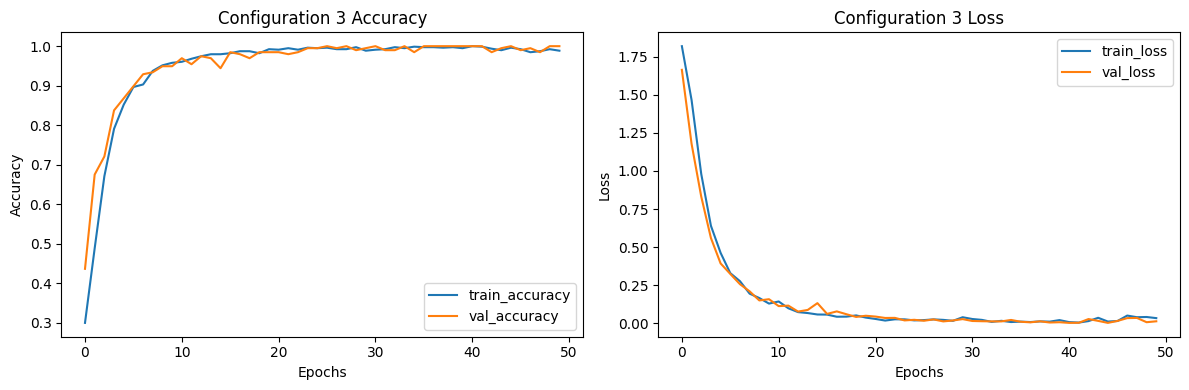

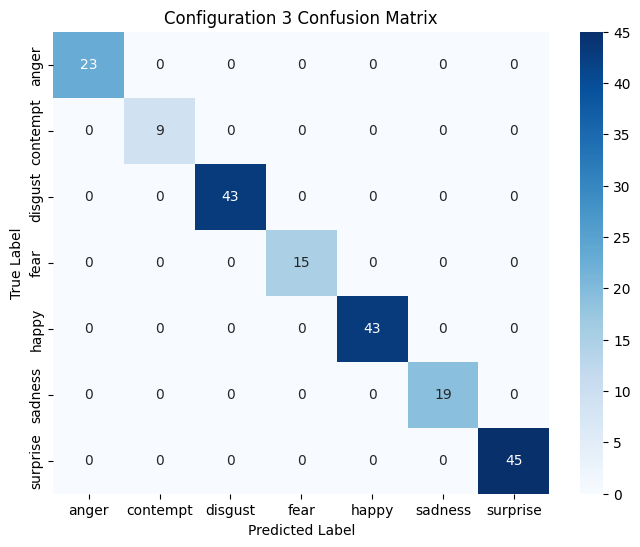

Test Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Test Loss: 0.0143
Training Configuration 4: {'conv_layers': 2, 'filters': 64, 'dense_layers': 1, 'dense_units': 64, 'dropout': 0.2, 'epochs': 30, 'batch_size': 32, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'}


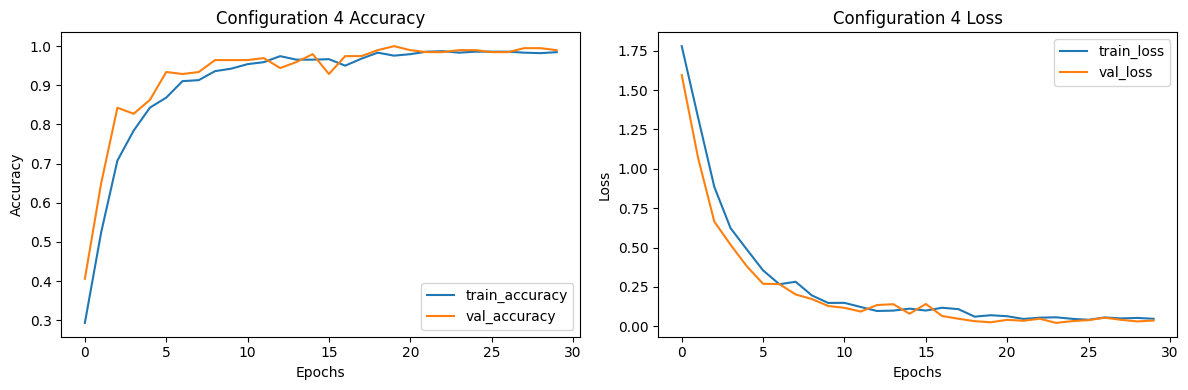

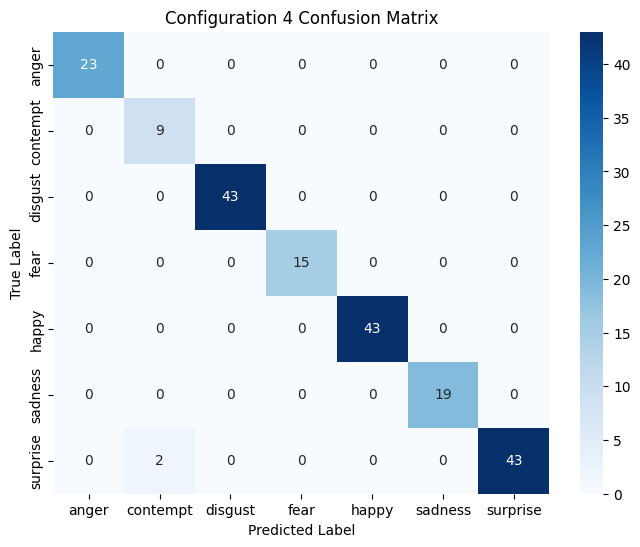

Test Accuracy: 0.9898, Precision: 0.9917, Recall: 0.9898, F1 Score: 0.9902
Test Loss: 0.0365
Training Configuration 5: {'conv_layers': 2, 'filters': 64, 'dense_layers': 1, 'dense_units': 128, 'dropout': 0.2, 'epochs': 30, 'batch_size': 32, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'}


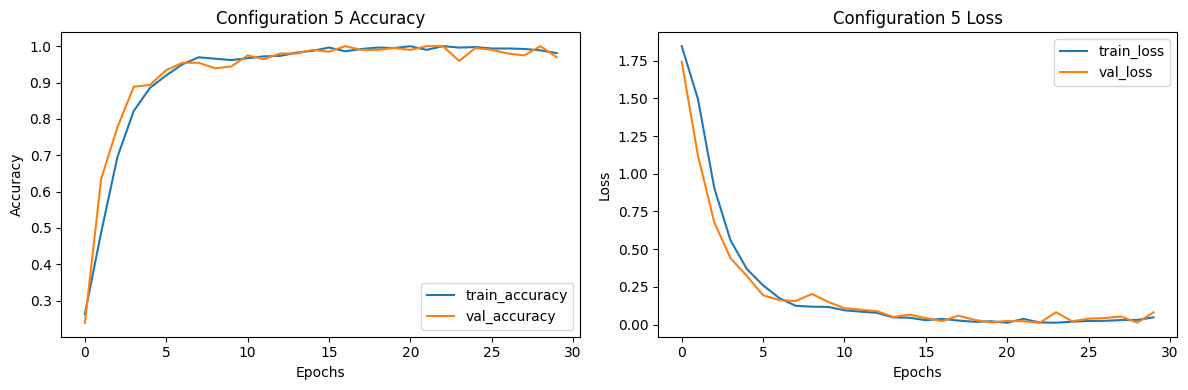

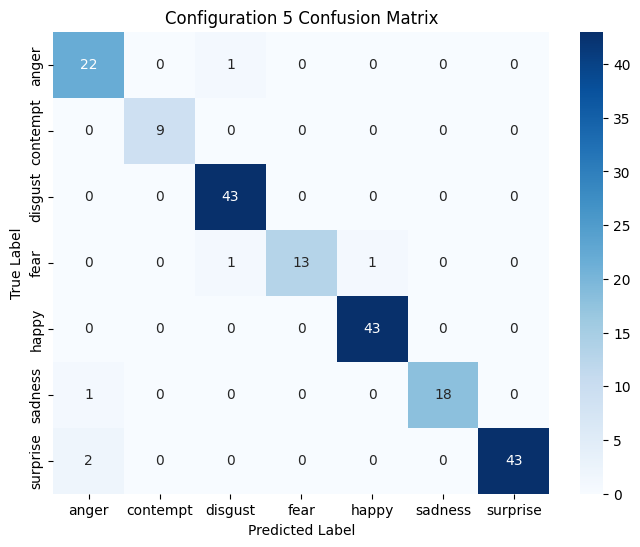

Test Accuracy: 0.9695, Precision: 0.9713, Recall: 0.9695, F1 Score: 0.9696
Test Loss: 0.0819


In [4]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import warnings

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
tf.get_logger().setLevel('ERROR')

# Set seeds for reproducibility
def set_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.keras.utils.set_random_seed(seed)
    tf.config.experimental.enable_op_determinism()

set_seeds(42)

# Define the path to the CK+ dataset folder
dataset_folder = r'C:/Users/user/Downloads/Thesis/linda_trials/CK+ Datasetset'

# Function to load images and extract labels
def load_images_and_labels(base_folder):
    images = []
    labels = []
    for label_folder in os.listdir(base_folder):
        label_path = os.path.join(base_folder, label_folder)
        if os.path.isdir(label_path):
            for filename in os.listdir(label_path):
                if filename.endswith('.png') or filename.endswith('.jpg') or filename.endswith('.jpeg'):
                    image_file = os.path.join(label_path, filename)
                    img = Image.open(image_file).convert('L')  # Convert to grayscale
                    img = img.resize((64, 64))  # Resize to 64x64 for consistency
                    img_array = np.array(img) / 255.0  # Normalize pixel values to [0, 1]
                    images.append(img_array)
                    labels.append(label_folder)  # The folder name is the label
    return np.array(images), np.array(labels)

# Load images and labels
try:
    images, labels = load_images_and_labels(dataset_folder)
    images = images.reshape(-1, 64, 64, 1)  # Reshape for CNN input
except Exception as e:
    print(f"Error loading images: {e}")

# Convert labels to one-hot encoding
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_categorical = to_categorical(labels_encoded)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels_categorical, test_size=0.2, random_state=42)

# Data augmentation generator
data_gen = ImageDataGenerator(
    shear_range=0.0,
    zoom_range=0.0,
    rotation_range=0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    horizontal_flip=True
)

# Top configurations from your list
configurations = [
    {'conv_layers': 1, 'filters': 64, 'dense_layers': 1, 'dense_units': 64, 'dropout': 0.2, 'epochs': 50, 'batch_size': 32, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'},
    {'conv_layers': 2, 'filters': 32, 'dense_layers': 1, 'dense_units': 64, 'dropout': 0.2, 'epochs': 30, 'batch_size': 32, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'},
    {'conv_layers': 2, 'filters': 32, 'dense_layers': 1, 'dense_units': 128, 'dropout': 0.2, 'epochs': 50, 'batch_size': 32, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'},
    {'conv_layers': 2, 'filters': 64, 'dense_layers': 1, 'dense_units': 64, 'dropout': 0.2, 'epochs': 30, 'batch_size': 32, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'},
    {'conv_layers': 2, 'filters': 64, 'dense_layers': 1, 'dense_units': 128, 'dropout': 0.2, 'epochs': 30, 'batch_size': 32, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'}
]

from sklearn.metrics import precision_score, recall_score, f1_score

# Train and evaluate each configuration
for idx, config in enumerate(configurations):
    print(f"Training Configuration {idx + 1}: {config}")
    
    # Model definition
    model = Sequential()
    model.add(InputLayer(input_shape=(64, 64, 1)))
    for _ in range(config['conv_layers']):
        model.add(Conv2D(config['filters'], kernel_size=(3, 3), activation=config['activation']))
        model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    for _ in range(config['dense_layers']):
        model.add(Dense(config['dense_units'], activation=config['activation']))
        model.add(Dropout(config['dropout']))
    model.add(Dense(len(np.unique(labels_encoded)), activation='softmax'))

    optimizer_instance = Adam(learning_rate=config['learning_rate'])
    model.compile(optimizer=optimizer_instance, loss='categorical_crossentropy', metrics=['accuracy'])

    # Train with data augmentation
    train_gen = data_gen.flow(X_train, y_train, batch_size=config['batch_size'])
    history = model.fit(train_gen, epochs=config['epochs'], validation_data=(X_test, y_test), verbose=0)

    # Evaluate the model
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    predictions = model.predict(X_test, verbose=0)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(y_test, axis=1)

    # Calculate additional metrics
    precision = precision_score(true_classes, predicted_classes, average='weighted')
    recall = recall_score(true_classes, predicted_classes, average='weighted')
    f1 = f1_score(true_classes, predicted_classes, average='weighted')

    # Plot accuracy and loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.title(f'Configuration {idx + 1} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title(f'Configuration {idx + 1} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Confusion matrix
    cm = confusion_matrix(true_classes, predicted_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(f'Configuration {idx + 1} Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Print metrics
    print(f"Test Accuracy: {test_acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
    print(f"Test Loss: {test_loss:.4f}")


### **Dataset Preprocessing:**
- **Images**: Loaded from a specified folder, converted to grayscale, resized to 64x64 pixels, and normalized to [0, 1].
- **Reshaping**: Images reshaped to `(64, 64, 1)` for compatibility with the CNN input.
- **Label Processing**: Labels are encoded using `LabelEncoder` and converted to one-hot encoding.

### **Data Splitting:**
- **Train/Test Split**: Data split into 80% training and 20% testing.

### **Data Augmentation:**
- **Configuration**: Horizontal flipping is applied to augment the training data (`horizontal_flip=True`).

### **Model Architectures (Configurations):**
Multiple configurations are tested, varying in the number of convolutional layers, filters, dense layers, units, dropout rates, epochs, batch sizes, and learning rates.

### **Configurations:**
1. **Configuration 1:**
   - **Conv Layers**: 1
   - **Filters**: 64
   - **Dense Layers**: 1
   - **Dense Units**: 64
   - **Dropout**: 0.2
   - **Epochs**: 50
   - **Batch Size**: 32
   - **Learning Rate**: 0.001

2. **Configuration 2:**
   - **Conv Layers**: 2
   - **Filters**: 32
   - **Dense Layers**: 1
   - **Dense Units**: 64
   - **Dropout**: 0.2
   - **Epochs**: 30
   - **Batch Size**: 32
   - **Learning Rate**: 0.001

3. **Configuration 3:**
   - **Conv Layers**: 2
   - **Filters**: 32
   - **Dense Layers**: 1
   - **Dense Units**: 128
   - **Dropout**: 0.2
   - **Epochs**: 50
   - **Batch Size**: 32
   - **Learning Rate**: 0.001

4. **Configuration 4:**
   - **Conv Layers**: 2
   - **Filters**: 64
   - **Dense Layers**: 1
   - **Dense Units**: 64
   - **Dropout**: 0.2
   - **Epochs**: 30
   - **Batch Size**: 32
   - **Learning Rate**: 0.001

5. **Configuration 5:**
   - **Conv Layers**: 2
   - **Filters**: 64
   - **Dense Layers**: 1
   - **Dense Units**: 128
   - **Dropout**: 0.2
   - **Epochs**: 30
   - **Batch Size**: 32
   - **Learning Rate**: 0.001

### **Training and Evaluation:**
- Each configuration is trained using `ImageDataGenerator` with horizontal flip enabled.
- Models are evaluated on the test set, and metrics such as accuracy, precision, recall, and F1 score are calculated.
- Results are visualized through accuracy/loss plots and confusion matrices.

### **Output Metrics:**
- **Accuracy**: Assesses the overall correctness of predictions.
- **Precision, Recall, F1 Score**: Provide a deeper understanding of model performance, especially in handling class imbalances.
- **Confusion Matrix**: Visualizes the true vs. predicted labels for each configuration.

# TO_do which of these config did we use? what optimization was used (validation set or test set is there another test set after validation? Refer to optmzan stra)